In [1]:
# 5. Лень, вредные привычки и доход
# Гипотеза: чем больше времени человек проводит перед телевизором, тем ниже его доход.
# Дополнительный анализ:
#     - как влияет курение на уровень дохода
#     - как влияет уровень употребления алкоголя на уровень дохода


In [2]:
from dataframes import dataframes # словарь датафреймов, ключи: 2010, 2012, 2014, 2016, 2018, 2021, 2022.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [3]:
dataframes_list = [dataframes['2010'], dataframes['2012'], dataframes['2014'], dataframes['2016'], dataframes['2018'], dataframes['2021'], dataframes['2022']]

Используемы в исследовании переменные:
- realrinc - реальный доход
- tvhours - время проведённое за телевизором

За лень будет взята переменная "tvhours", которая задаёт вопрос: "Сколько часов в день респондент проводит за просмотром телевизора"
- 0-24 часа в день

In [4]:
dataframes_list[0].tvhours.unique()

array([ 1.,  0.,  5.,  3., nan,  4.,  2.,  6.,  7.,  9., 12.,  8., 20.,
       23., 13., 10., 18., 21., 24., 14., 15., 16., 11.])

# Создаём датафрейм

In [5]:
cols = ['realrinc','tvhours']
df = pd.concat(
    [frame[frame.columns.intersection(cols)].copy() for frame in dataframes_list],
    ignore_index=True
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19952 entries, 0 to 19951
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tvhours   13245 non-null  float64
 1   realrinc  11667 non-null  float64
dtypes: float64(2)
memory usage: 311.9 KB


In [6]:
df.shape

(19952, 2)

# Сразу удаляем лишние данные

In [7]:
df = df[df.realrinc.notna() & df.tvhours.notna()]
df.shape

(7777, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7777 entries, 0 to 19951
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tvhours   7777 non-null   float64
 1   realrinc  7777 non-null   float64
dtypes: float64(2)
memory usage: 182.3 KB


In [9]:
df['realrinc'] = df['realrinc'].apply(lambda x: x if x < 100_000 else 100_000)

# Проверяем данные

Гистограмма для дохода:

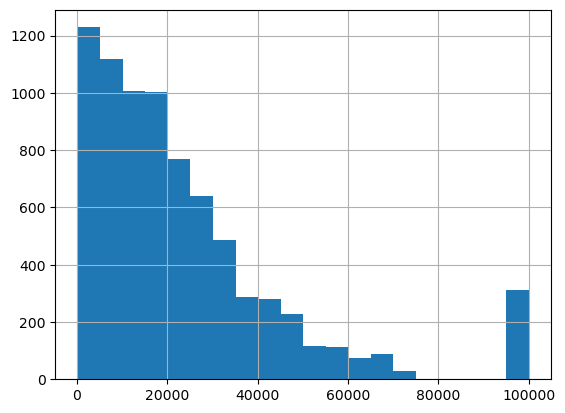

In [10]:
df.realrinc.hist(bins=20);

Гистограмма для времени у телевизора:

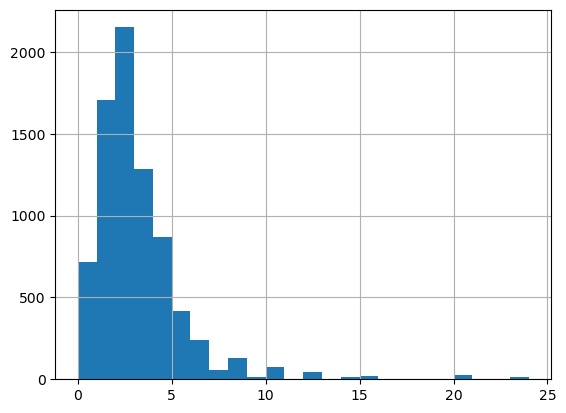

In [11]:
df.tvhours.hist(bins=24);

Коробка с усами для дохода и времени у телевизора:

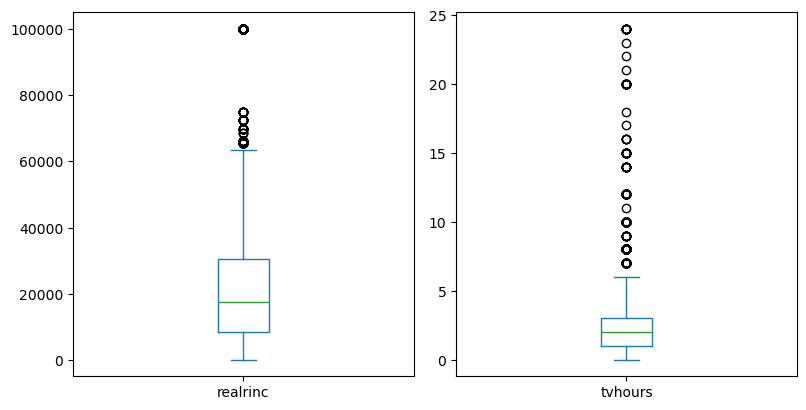

In [12]:
df[['realrinc', 'tvhours']].plot(kind='box', subplots=True, layout=(2, 3), figsize=(12, 8), showfliers=True)
plt.tight_layout()

# Проводим анализ

## Зависимость уровня дохода от времени просмотра телевизора в день

In [13]:
vals = df.groupby('tvhours').realrinc.mean().reset_index()
vals.head()

,tvhours,realrinc
0,0.0,24157.878671
1,1.0,28264.355741
2,2.0,24110.178140
3,3.0,23558.954545
4,4.0,19886.221420


Проверяем количество данных для каждого значения

In [14]:
check = df.groupby('tvhours').count()
check

,realrinc
tvhours,
0.0,715
1.0,1707
2.0,2150
3.0,1287
4.0,866
5.0,415
6.0,239
7.0,59
8.0,132


Для высоких значений времени выборка людей очень маленькая, поэтому стоит воспринимать значения только до 8 часов включительно

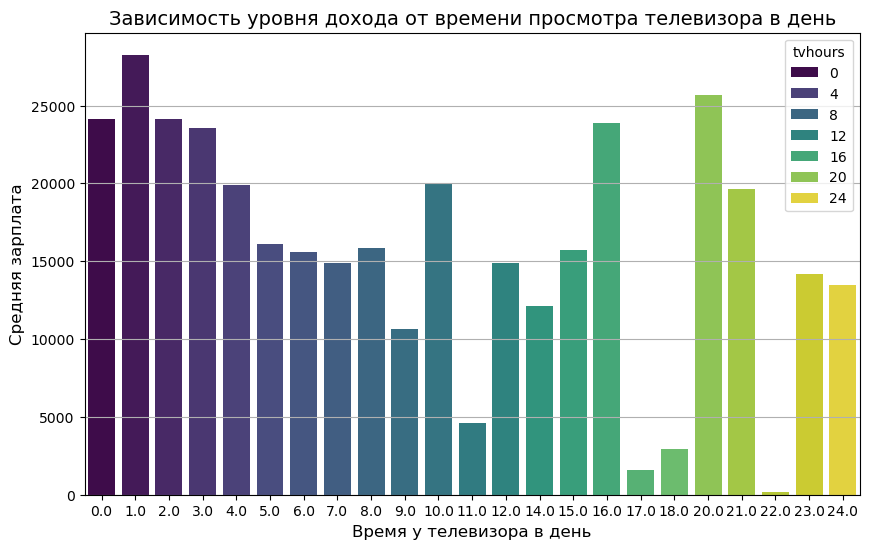

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='tvhours', y='realrinc', data=vals, hue='tvhours', palette='viridis')

plt.title('Зависимость уровня дохода от времени просмотра телевизора в день', fontsize=14)
plt.xlabel('Время у телевизора в день', fontsize=12)
plt.ylabel('Cредняя зарплата', fontsize=12)
plt.grid(axis='y');

Учитывая, что мы рассматриваем значения только до 8 часов включительно видим, что зависимость действительно есть. С ростом времени просмотра средний доход у группы людей начинает уменьшаться

Описательная статистика для датафрейма

In [16]:
df.describe()

,tvhours,realrinc
count,7777.000000,7777.000000
mean,2.709142,23393.239617
std,2.528034,21914.740464
min,0.000000,204.500000
25%,1.000000,8512.500000
50%,2.000000,17550.000000
75%,3.000000,30645.000000
max,24.000000,100000.000000


# Аналитика

Построим модель линейной регрессии. Целевая переменная - доход, объясняющая переменная - время перед телевизором.

In [17]:
import statsmodels.api as sm

In [18]:
X = df['tvhours'].values.reshape(-1, 1)
y = df['realrinc'].values

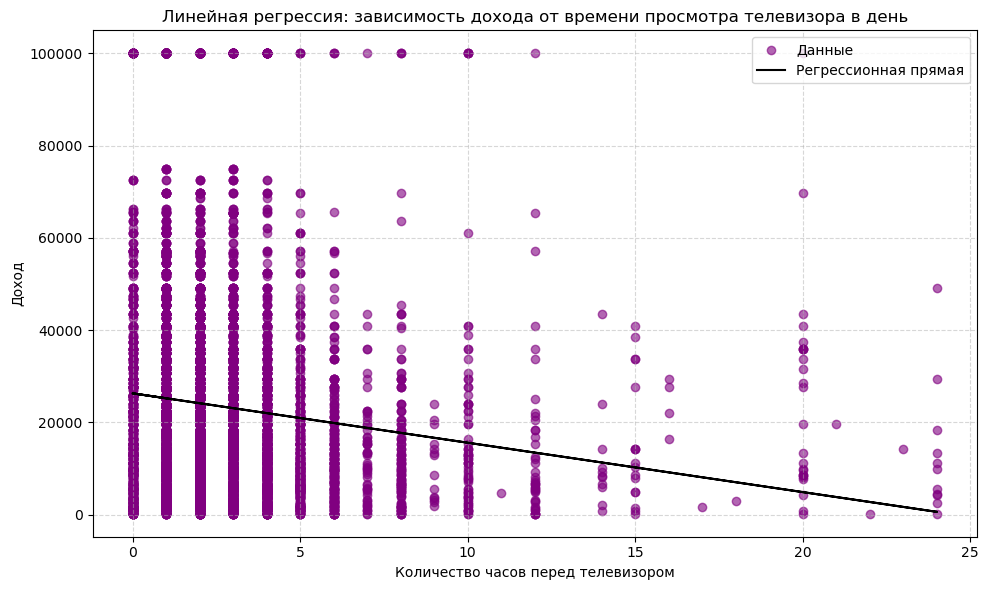

In [19]:
X_sm = sm.add_constant(X)

model_sm = sm.OLS(y, X_sm).fit()

y_pred = model_sm.predict(X_sm)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='purple', alpha=0.6, label='Данные')
plt.plot(X, y_pred, color='black', label='Регрессионная прямая')

plt.xlabel('Количество часов перед телевизором')
plt.ylabel('Доход')
plt.title('Линейная регрессия: зависимость дохода от времени просмотра телевизора в день')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Как видим по графику, чем выше количество часов перед телевизором, тем ниже доход.  
Рассмотрим характеристики модели.

In [20]:
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     120.4
Date:                Wed, 04 Jun 2025   Prob (F-statistic):           8.45e-28
Time:                        23:31:53   Log-Likelihood:                -88705.
No. Observations:                7777   AIC:                         1.774e+05
Df Residuals:                    7775   BIC:                         1.774e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.629e+04    361.490     72.735      0.0

Исходя и p-value можем сделать вывод, что свободный член и количество времени перед телевизором значимые переменные, однако в целом характеристики модели достаточно низкие, что говорит о слабой предсказательной способности модели.

# Выводы

Исходя из получнных результатов можем сделать вывод, что существует связь между количеством времени перед телевизором и доходом, а именно чем больше времени человек проводит перед телевизором, тем ниже его доход. Однако данная связь несущественна.